# BIZI data

Let's analyze the evolution of uses of the public bicycles system in Zaragoza. The data goes from June 2008 to June 2019. 

In [1]:
import pymc3 as pm
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

plt.style.use('seaborn-darkgrid')

In [2]:
path = "bizi/"
all_files = glob.glob(os.path.join(path, "*.csv"))

df = pd.concat([pd.read_csv(f, sep=";", header=0) for f in all_files])

In [3]:
df['DataTimeRemoval'] =  pd.to_datetime(df['DataTimeRemoval'], 
                                        format='%Y%m%d %H:%M:%S')
df = df.sort_values(by="DataTimeRemoval")
df

,CustID,CustSex,LustroNacimiento,DataTimeRemoval,Removal_Station,DateTime_Arrival,Arrival_station,LocationLength
0,158,F,16,2008-05-28 10:55:06,10,2008-05-28 11:04:32.000,11,9
1,391,F,16,2008-05-28 10:55:24,10,2008-05-28 11:04:49.000,11,9
2,408,F,16,2008-05-28 10:55:52,10,2008-05-28 11:04:48.000,11,8
3,441,F,16,2008-05-28 10:56:00,10,2008-05-28 11:04:47.000,11,8
4,406,F,16,2008-05-28 10:56:12,10,2008-05-28 11:05:01.000,11,8
...,...,...,...,...,...,...,...,...
899109,71686,M,18,2019-07-14 00:55:02,99,2019-07-14 01:23:00.950,46,27
899110,93235,M,17,2019-07-14 00:55:29,100,2019-07-14 01:04:18.980,53,8
899111,83379,M,19,2019-07-14 00:57:14,43,2019-07-14 01:04:19.027,49,7
899112,98468,M,20,2019-07-14 00:57:47,55,2019-07-14 01:52:10.330,4,54


In [4]:
df["Year/Week"] = df["DataTimeRemoval"].dt.to_period('M').dt.to_timestamp()

In [5]:
df = df.groupby(["Year/Week"]).size().reset_index(name="counts")
df = df.sort_values(by="Year/Week")
df = df.iloc[1:-1]
df

,Year/Week,counts
1,2008-06-01,25478
2,2008-07-01,35894
3,2008-08-01,33281
4,2008-09-01,35003
5,2008-10-01,28573
...,...,...
129,2019-02-01,141482
130,2019-03-01,153041
131,2019-04-01,131069
132,2019-05-01,160803


Let's plot the datapoints, corresponding to the total uses per week.

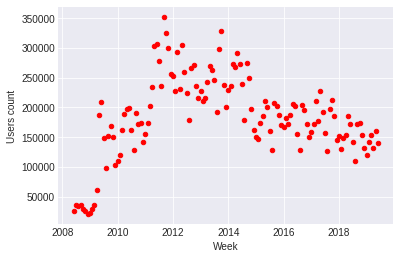

In [6]:
df.plot(x='Year/Week', y='counts', kind='scatter', color='red')
plt.ylabel("Users count")
plt.xlabel("Week");

In [7]:
points = df["counts"]

We will consider a model in which our data is assumed to be generated according to a negative binomial distribution.

In [8]:
def create_bikes_model(n_switchpoints):
    with pm.Model() as model:
        def create_switchpoint(id, lower, upper):
            return pm.DiscreteUniform(f'switchpoint_{id}', lower=lower, upper=upper)

        def create_rate(id, lower, upper):
            return pm.Uniform(f'rate_{id}', lower=lower, upper=upper) #average as a free parameter

        def build_switch(id):
            if id == 0:
                return pm.math.switch(switchpoints[0] >= weeks, rates[id], rates[id+1])
            else:
                return pm.math.switch(switchpoints[id] >= weeks, build_switch(id-1), rates[id+1])

        switchpoints = [create_switchpoint(0, 4, len(df["Year/Week"]) - n_switchpoints)]
        for i in range(1, n_switchpoints):
            switchpoints.append(create_switchpoint(i, switchpoints[i-1]+3, len(df["Year/Week"])-n_switchpoints+i))

        rates = []
        rates.append(create_rate(0, 0, 70000))
        rates.append(create_rate(1, 100000, 250000))
        rates.append(create_rate(2, 150000, 350000))
        
        if n_switchpoints == 4:
            rates.append(create_rate(3, 100000, 250000))
            rates.append(create_rate(4, 100000, 200000))
           
        if n_switchpoints == 5 or n_switchpoints == 6:
            rates.append(create_rate(3, 100000, 350000))
            rates.append(create_rate(4, 100000, 250000))
            rates.append(create_rate(5, 100000, 200000))
         
        if n_switchpoints == 6:
            rates.append(create_rate(6, 100000, 200000))            

        weeks = np.arange(0, len(df["Year/Week"]))
        variance = pm.Uniform('variance', 1, 100000) 

        rate = build_switch(n_switchpoints-1)

        uses = pm.NegativeBinomial('uses', rate, variance, observed=points)
        #uses = pm.Poisson('uses', rate,observed=points)
    
    return model    

Let's try a model with 4 switchpoints.

In [9]:
with create_bikes_model(4) as model:
    trace = pm.sample(100000, tune = 5000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint_3]
>>Metropolis: [switchpoint_2]
>>Metropolis: [switchpoint_1]
>>Metropolis: [switchpoint_0]
>NUTS: [variance, rate_4, rate_3, rate_2, rate_1, rate_0]


/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 5_000 tune and 100_000 draw iterations (20_000 + 400_000 draws total) took 146 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [10]:
az.summary(trace, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint_0,9.713,0.452,9.000,10.000,0.002,0.002,35517.0,35517.0,1.0
switchpoint_1,32.347,0.795,31.000,33.000,0.010,0.007,36688.0,49609.0,1.0
switchpoint_2,75.616,4.148,72.000,77.000,0.286,0.202,1356.0,539.0,1.0
switchpoint_3,113.365,7.813,99.000,127.000,0.374,0.264,1732.0,524.0,1.0
rate_0,31513.970,2201.958,27130.493,35681.277,7.694,5.440,83646.0,161815.0,1.0
rate_1,158991.293,6603.175,146160.603,171946.728,16.803,11.882,153201.0,147669.0,1.0
rate_2,255345.991,8559.320,240383.598,270061.750,156.678,122.350,5774.0,1687.0,1.0
rate_3,179231.128,10646.883,165382.162,191273.533,626.601,463.715,1682.0,521.0,1.0
rate_4,149997.626,8484.074,133838.401,168128.344,187.510,139.044,2464.0,764.0,1.0
variance,30.679,3.914,23.163,38.394,0.009,0.006,183355.0,244727.0,1.0


array([[<AxesSubplot:title={'center':'switchpoint_0'}>,
        <AxesSubplot:title={'center':'switchpoint_0'}>],
       [<AxesSubplot:title={'center':'switchpoint_1'}>,
        <AxesSubplot:title={'center':'switchpoint_1'}>],
       [<AxesSubplot:title={'center':'switchpoint_2'}>,
        <AxesSubplot:title={'center':'switchpoint_2'}>],
       [<AxesSubplot:title={'center':'switchpoint_3'}>,
        <AxesSubplot:title={'center':'switchpoint_3'}>],
       [<AxesSubplot:title={'center':'rate_0'}>,
        <AxesSubplot:title={'center':'rate_0'}>],
       [<AxesSubplot:title={'center':'rate_1'}>,
        <AxesSubplot:title={'center':'rate_1'}>],
       [<AxesSubplot:title={'center':'rate_2'}>,
        <AxesSubplot:title={'center':'rate_2'}>],
       [<AxesSubplot:title={'center':'rate_3'}>,
        <AxesSubplot:title={'center':'rate_3'}>],
       [<AxesSubplot:title={'center':'rate_4'}>,
        <AxesSubplot:title={'center':'rate_4'}>],
       [<AxesSubplot:title={'center':'variance'}>,
  

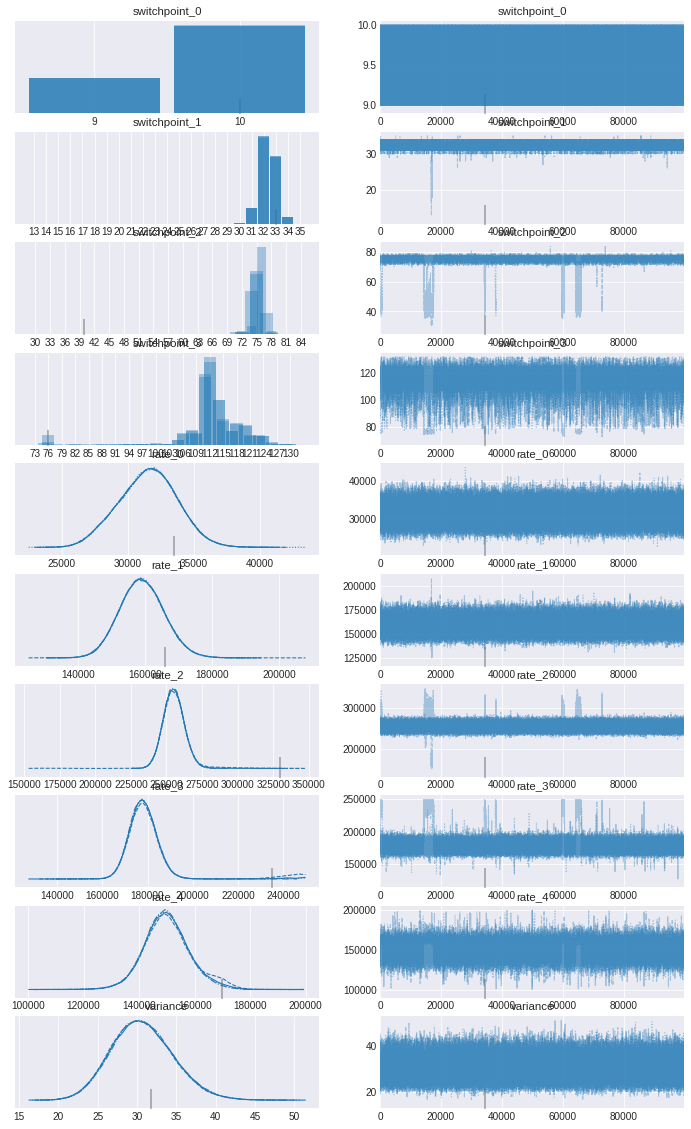

In [11]:
az.plot_trace(trace)

For completeness, let's run the model adding one and two more switchpoints.

In [12]:
#running traces for different n_switchpoint
traces = [] 
for i in range(4, 7):
    print(f"Running model with {i} switchpoints")
    with create_bikes_model(i) as model:
        traces.append(pm.sample(10000, tune = 5000, return_inferencedata=True))

Running model with 4 switchpoints


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint_3]
>>Metropolis: [switchpoint_2]
>>Metropolis: [switchpoint_1]
>>Metropolis: [switchpoint_0]
>NUTS: [variance, rate_4, rate_3, rate_2, rate_1, rate_0]


/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 23 seconds.
The number of effective samples is smaller than 10% for some parameters.


Running model with 5 switchpoints


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint_4]
>>Metropolis: [switchpoint_3]
>>Metropolis: [switchpoint_2]
>>Metropolis: [switchpoint_1]
>>Metropolis: [switchpoint_0]
>NUTS: [variance, rate_5, rate_4, rate_3, rate_2, rate_1, rate_0]


/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 32 seconds.
The acceptance probability does not match the target. It is 0.5205843994483256, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7077524756248568, b

Running model with 6 switchpoints


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint_5]
>>Metropolis: [switchpoint_4]
>>Metropolis: [switchpoint_3]
>>Metropolis: [switchpoint_2]
>>Metropolis: [switchpoint_1]
>>Metropolis: [switchpoint_0]
>NUTS: [variance, rate_6, rate_5, rate_4, rate_3, rate_2, rate_1, rate_0]


/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 39 seconds.
There were 427 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.15177650035849943, but should be close to 0.8. Try to increase the number of tuning st

In [13]:
prediction = [] 
m=0
for i in range(4, 7):
    print(f"Running model with {i} switchpoints")
    with create_bikes_model(4) as model:
        prediction.append(pm.sample_posterior_predictive(traces[m], 10000))
        m=m+1

Running model with 4 switchpoints


/home/jupyter-marta/.local/lib/python3.7/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Running model with 5 switchpoints


Running model with 6 switchpoints


Let's plot the evolution:

In [15]:
def layout (n_switchpoints, i):
    trace=traces[i]
    dates = pd.to_datetime(df["Year/Week"]).dt.strftime("%Y-%m-%d")
    plot_dates = [dates[i] for i in range(1, len(dates)-1, 20)]

    posterior_quantile = np.percentile(prediction[i]["uses"], [2.5, 25, 50, 75, 97.5], axis=0)

    # Plot daily number of admissions
    plt.plot(
        dates, posterior_quantile[2, :],
        color='b', label='posterior median', lw=2)

    plt.fill_between(
        dates, posterior_quantile[0, :], posterior_quantile[4, :],
        color='b', label='95% quantile', alpha=.2)

    plt.plot(
          dates, df["counts"],
          '--o', color='k', markersize=3,
          label='Observed', alpha=.8)

    for j in range(0, n_switchpoints):
        plt.vlines(np.median(trace["posterior"]["switchpoint_%s" %(j)]), df["counts"].min(), df["counts"].max(), color='C1')

    plt.xticks(plot_dates, rotation=30)
    plt.ylabel('Uses', fontsize='large')
    plt.xlabel('Week', fontsize='large')
    plt.title('With %s switchpoints'%n_switchpoints)

    fontsize = 'medium'
    plt.legend(loc='upper left', fontsize=fontsize)

    return plt.tight_layout();
    

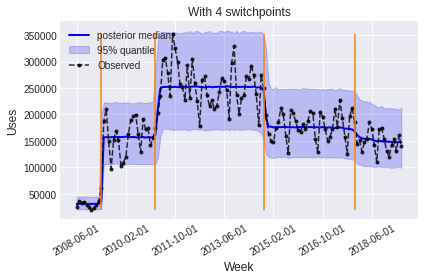

In [16]:
layout(4,0)

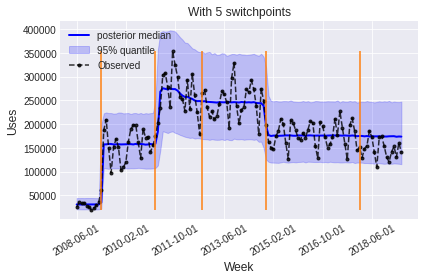

In [17]:
layout(5,1)

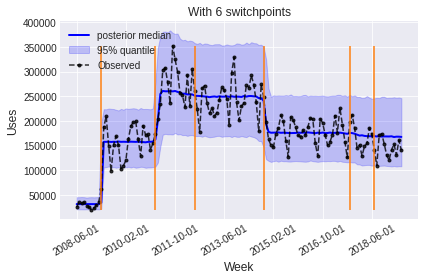

In [18]:
layout(6,2)

array([[<AxesSubplot:title={'center':'switchpoint_0'}>,
        <AxesSubplot:title={'center':'switchpoint_0'}>],
       [<AxesSubplot:title={'center':'switchpoint_1'}>,
        <AxesSubplot:title={'center':'switchpoint_1'}>],
       [<AxesSubplot:title={'center':'switchpoint_2'}>,
        <AxesSubplot:title={'center':'switchpoint_2'}>],
       [<AxesSubplot:title={'center':'switchpoint_3'}>,
        <AxesSubplot:title={'center':'switchpoint_3'}>],
       [<AxesSubplot:title={'center':'switchpoint_4'}>,
        <AxesSubplot:title={'center':'switchpoint_4'}>],
       [<AxesSubplot:title={'center':'rate_0'}>,
        <AxesSubplot:title={'center':'rate_0'}>],
       [<AxesSubplot:title={'center':'rate_1'}>,
        <AxesSubplot:title={'center':'rate_1'}>],
       [<AxesSubplot:title={'center':'rate_2'}>,
        <AxesSubplot:title={'center':'rate_2'}>],
       [<AxesSubplot:title={'center':'rate_3'}>,
        <AxesSubplot:title={'center':'rate_3'}>],
       [<AxesSubplot:title={'center':'r

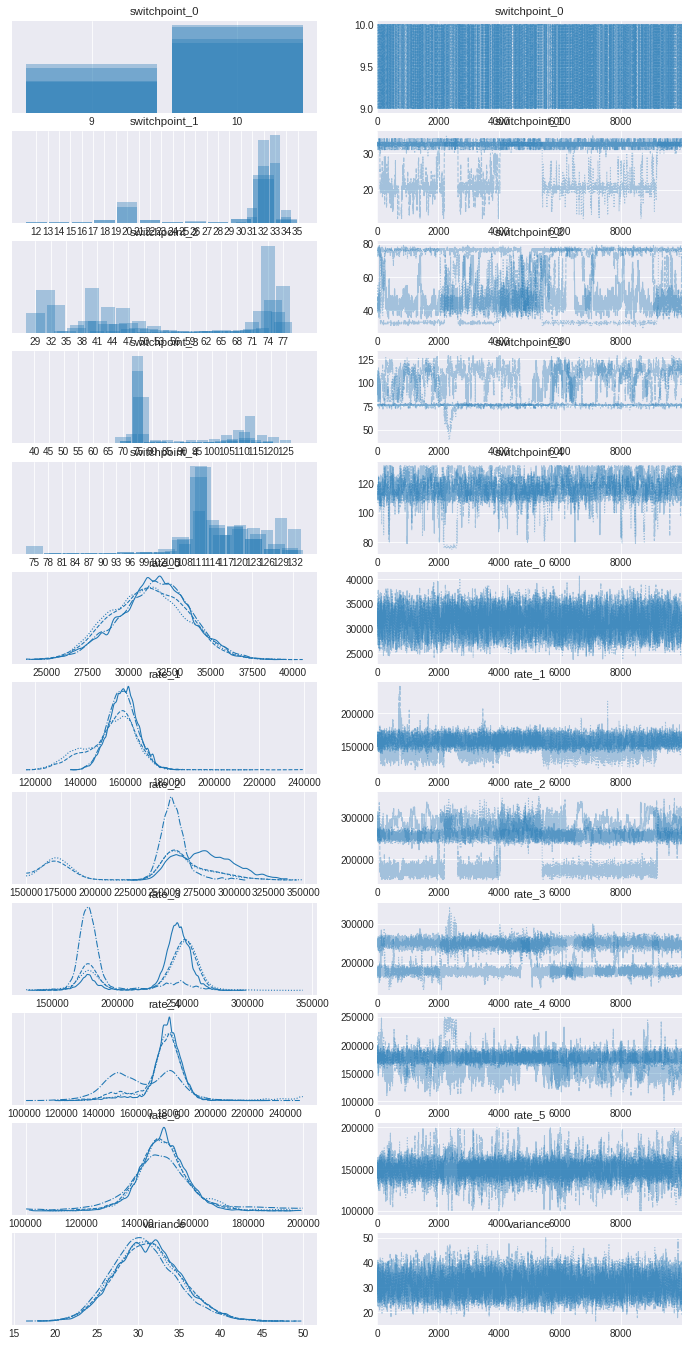

In [19]:
az.plot_trace(traces[1])

In [20]:
loo_4 = az.loo(traces[0], model)
loo_5 = az.loo(traces[1], model)
loo_6 = az.loo(traces[2], model)

df_comp_loo = az.compare({"four": traces[0], "five": traces[1], "six": traces[2]})
df_comp_loo


/home/jupyter-marta/.local/lib/python3.7/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/jupyter-marta/.local/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/home/jupyter-marta/.local/lib/python3.7/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/tljh/user/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
four,0,-1567.634142,12.607474,0.000000,1.000000e+00,11.970789,0.000000,True,log
five,1,-1568.930354,15.972545,1.296212,1.665335e-16,11.934379,1.065277,True,log
six,2,-1569.651696,16.863860,2.017554,0.000000e+00,12.144167,1.308775,True,log


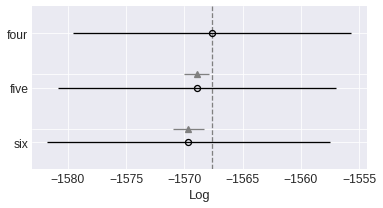

In [22]:
az.plot_compare(df_comp_loo, insample_dev=False);

According to the loo, the best model is the one with four switchpoints. Yet, when we look at the plot we can see that all models are compatible. Thus, we can choose whichever we prefer, or the one which is more reasonable given extra information. According to the plotted evolution and news, we conclude:

- The service started in may 2008.
- The 1$^{st}$ switchpoint would correspond to the first service extension in April and October 2019.
- 2$^{nd}$ switchpoint: biggest and last extension of the service in May 2011.
- 3$^{rd}$ switchpoint: riding on sidewalks ban in 2014 (coming into force at the end of the year).
- 4$^{th}$ switchpoint: electric scooter arrival to the city in the first part of 2018.

Sources:

https://www.elperiodicodearagon.com/aragon/2018/04/15/bizi-boom-supervivencia-46794902.html

https://www.elperiodicodearagon.com/aragon/2018/07/23/boom-patinete-electrico-llega-zaragoza-46757738.html

